# This document contains the implementation of SVM, Decision Tree and MLP

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import datasets, svm, metrics
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

Dataset Cources

https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

https://www.kaggle.com/datasets/henrysue/online-shoppers-intention/data


• Administrative: This is the number of pages of this type (administrative) that the user visited.<br>
• Administrative_Duration: This is the amount of time spent in this category of pages.<br>
• Informational: This is the number of pages of this type (informational) that the user visited.<br>
• Informational_Duration: This is the amount of time spent in this category of pages.<br>
• ProductRelated: This is the number of pages of this type (product related) that the user visited.<br>
• ProductRelated_Duration: This is the amount of time spent in this category of pages.<br>
• BounceRates: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.<br>
• ExitRates: The percentage of pageviews on the website that end at that specific page.<br>
• PageValues: The average value of the page averaged over the value of the target page and/or the completion of an eCommerce transaction.<br>
• SpecialDay: This value represents the closeness of the browsing date to special days or holidays (e.g., Mother's Day or Valentine's Day) in which the transaction is more likely to be finalized.<br>
• Month: Contains the month the pageview occurred, in string form.<br>
• OperatingSystems: An integer value representing the operating system that the user was on when viewing the page.<br>
• Browser: An integer value representing the browser that the user was using to view the page.<br>
• Region: An integer value representing which region the user is located in.<br>
• TrafficType: An integer value representing what type of traffic the user is categorized into.<br>
• VisitorType: A string representing whether a visitor is New Visitor, Returning Visitor, or Other.<br>
• Weekend: A boolean representing whether the session is on a weekend.<br>
Revenue: A boolean representing whether or not the user completed the purchase.<br>

# FUNCTIONS

In [2]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates
    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers using interquartile range
#source: https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule#:~:text=A%20commonly%20used%20rule%20says,3%20%2B%201.5%20%E2%8B%85%20IQR%20%E2%80%8D%20.
def outliers_check(data, numeric_cols):
    outliers_sum =[]

    for col in (numeric_cols):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


#Function to remove duplicates
def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum() #get duplicate sum
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()] #drop duplicates
        print("Duplicated rows have been removed")
        return data

    
#function to remove outliers using Iter quartile range
def remove_outliers(data, numeric_cols):
    
    for col in (numeric_cols):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data


#function to replace values with "unknown" with mode
def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "other" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data

    
#one hot encoding
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

# EDA

In [4]:
data = read_dataset("online_shoppers_intention.csv") #read dataset

The dataset contains 12,330 rows and 18 columns.
There are no null items in the dataset
There are duplicates in the dataset


In [5]:
data.duplicated().sum() #get duplicate sum

125

In [6]:
data = remove_duplicates(data) #remove duplicates

Number of duplicated rows in dataset = 125
Duplicated rows have been removed


In [7]:
data.duplicated().sum() #duplicate sum

0

In [8]:
pd.set_option('display.max_columns', None)

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

In [10]:
#Summary statistics of the dataset
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [11]:
#Class imbalance
data['Revenue'].value_counts()

False    10297
True      1908
Name: Revenue, dtype: int64

In [12]:
#Categorize data into numeric and categorical

#convert boolean columns to string
data['Weekend'] = data['Weekend'].astype('str')
data['Revenue'] = data['Revenue'].astype('str')

numeric_cols, categorical_cols = categorize_data(data)

# Visualisations

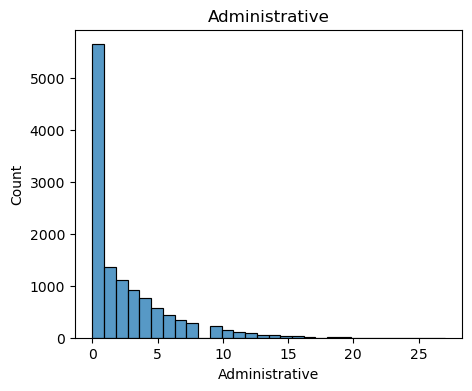

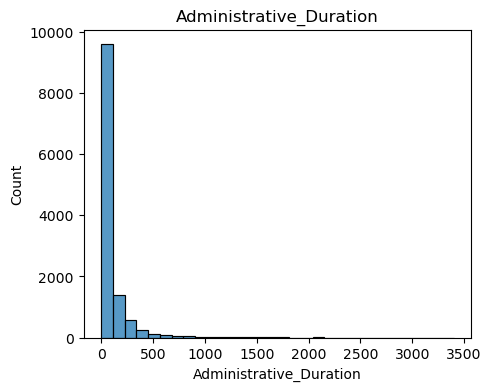

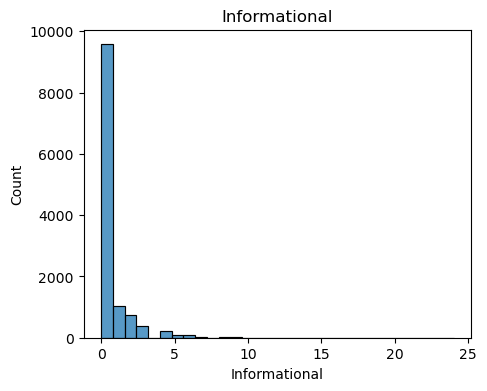

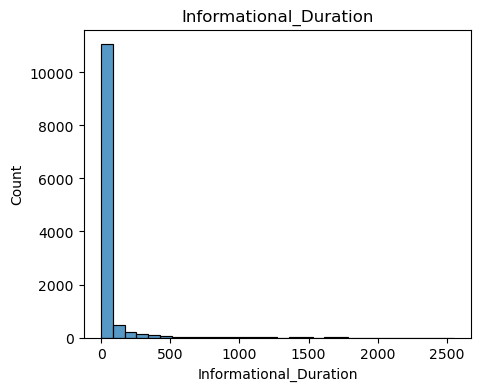

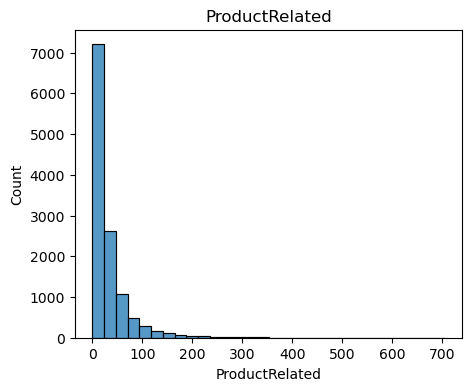

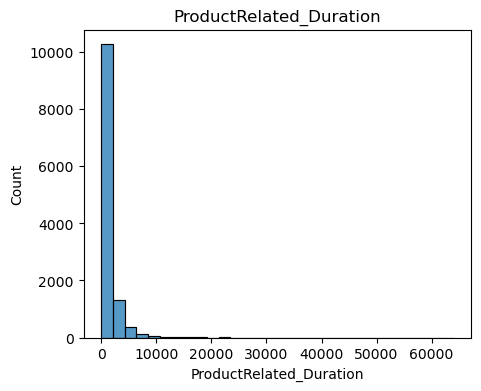

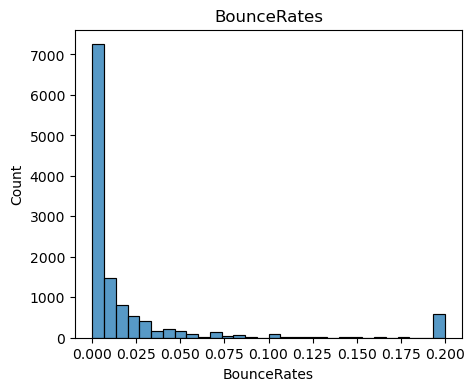

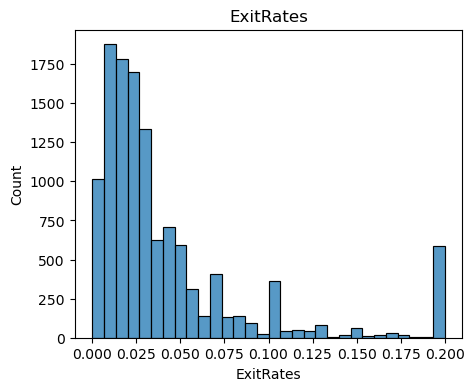

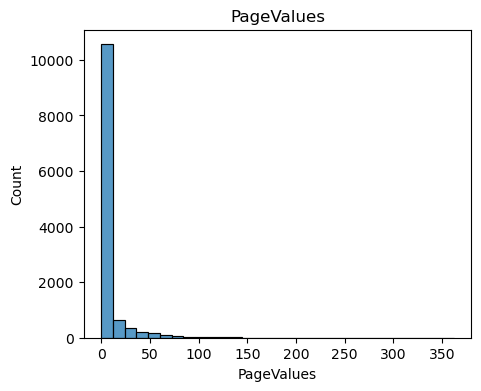

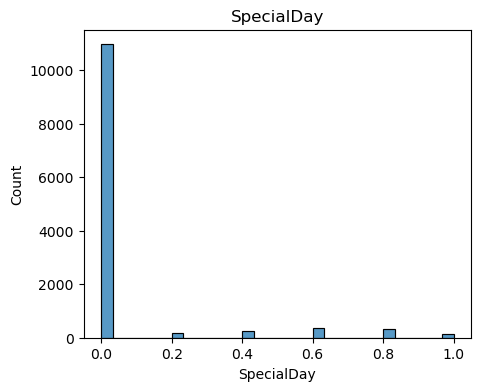

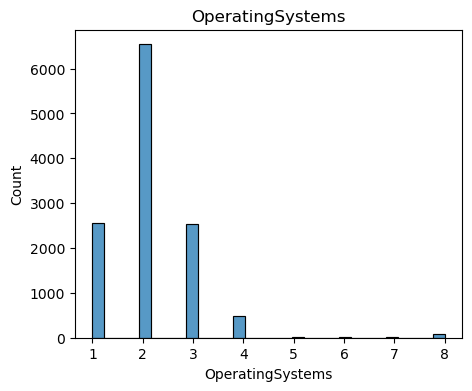

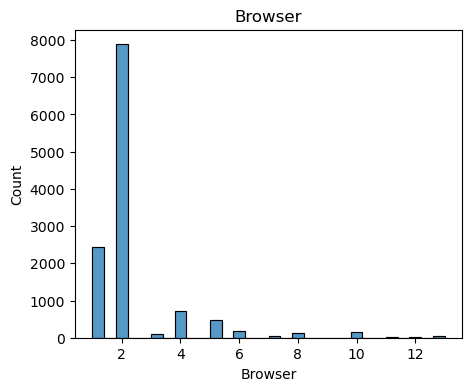

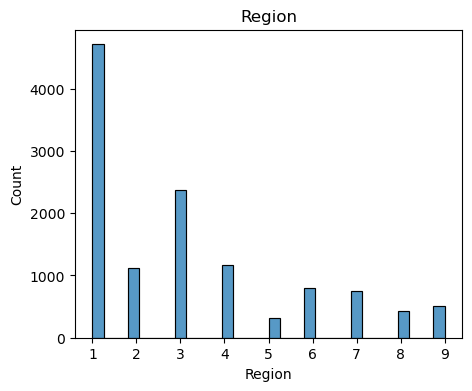

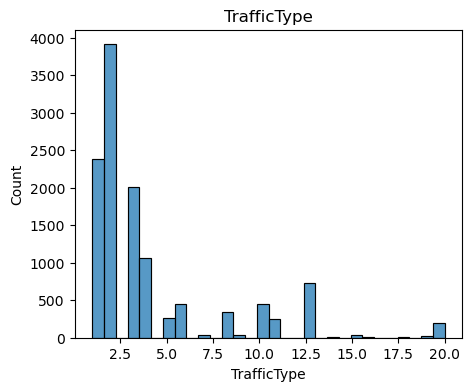

In [14]:
#Check distributions of numeric columns
for i in range (len(numeric_cols)):
    plt.figure(figsize=(5,4))
    sns.histplot(data[numeric_cols[i]], bins=30)
    plt.title(numeric_cols[i])

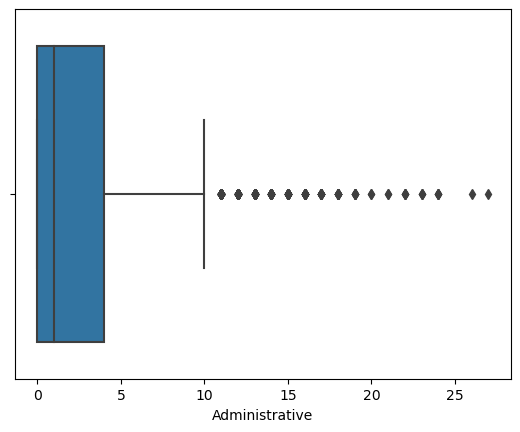

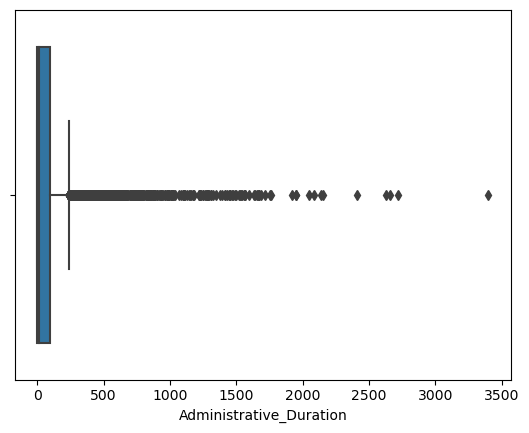

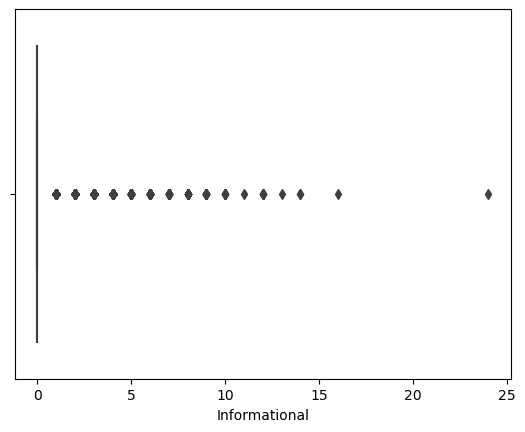

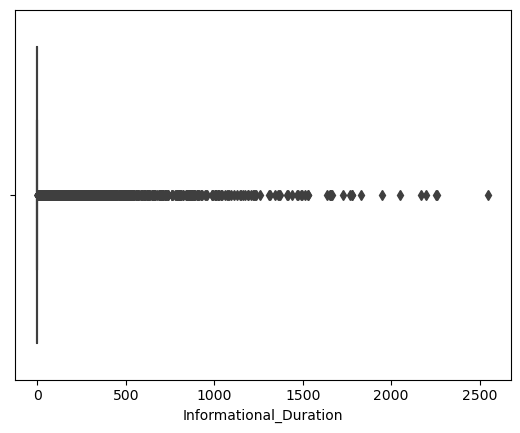

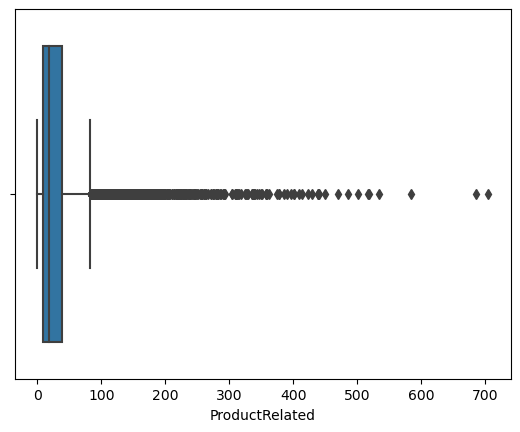

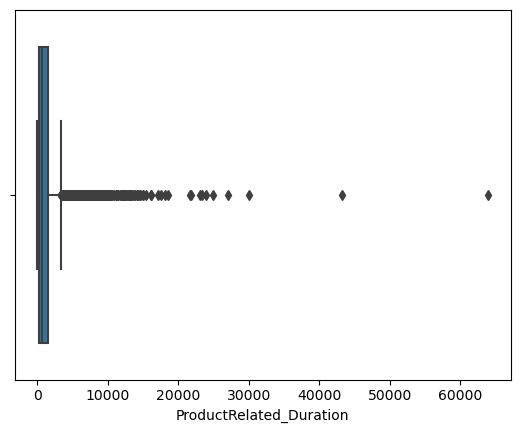

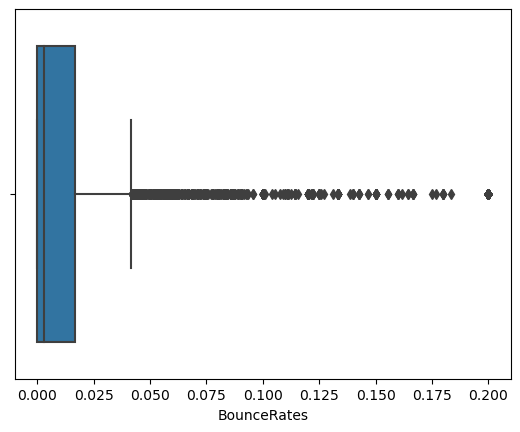

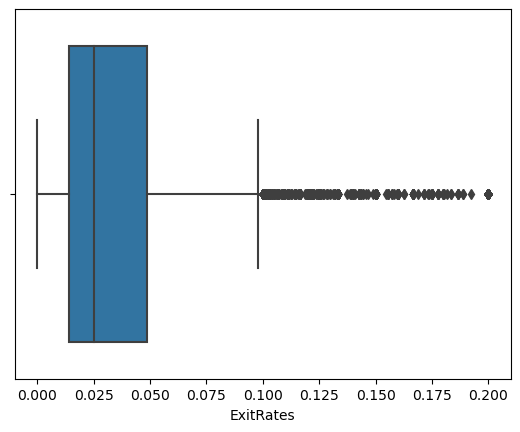

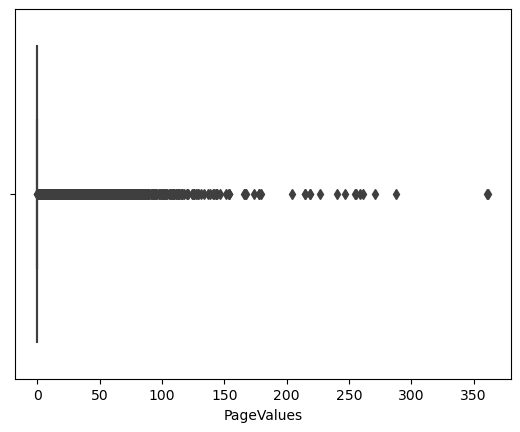

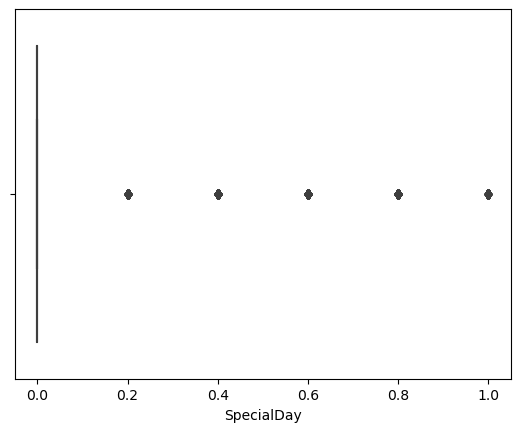

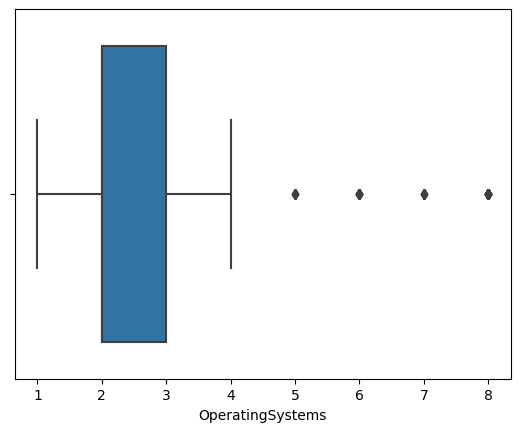

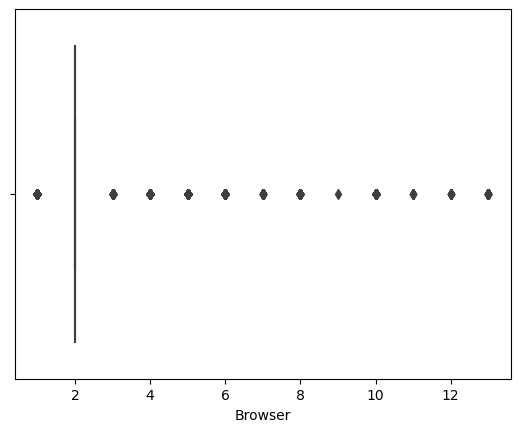

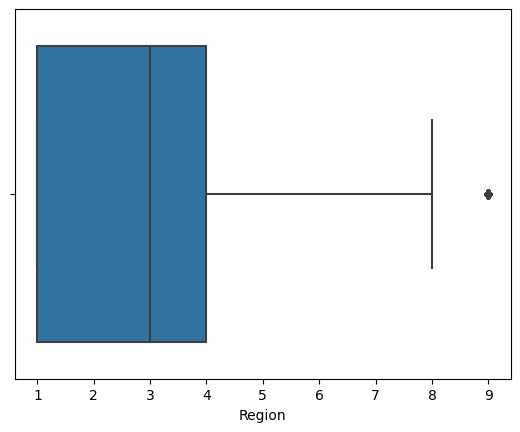

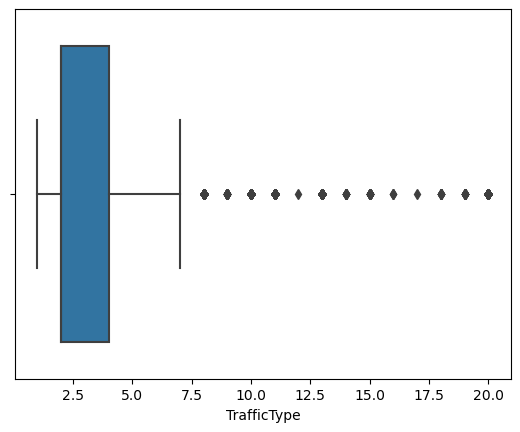

In [15]:
#Box plots for numeric columns
for i in range (len(numeric_cols)):
    plt.figure()
    sns.boxplot(x=data[numeric_cols[i]], data=data)

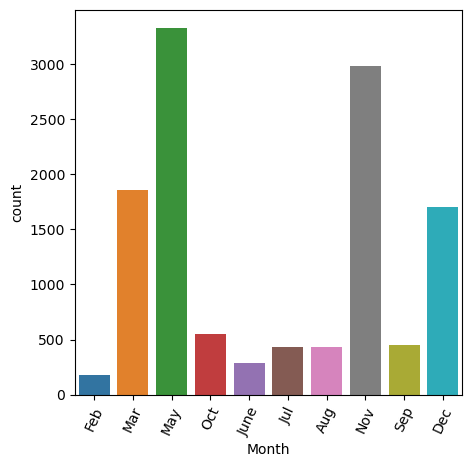

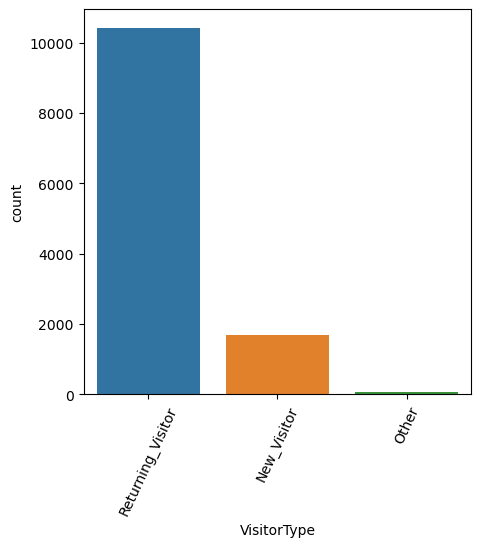

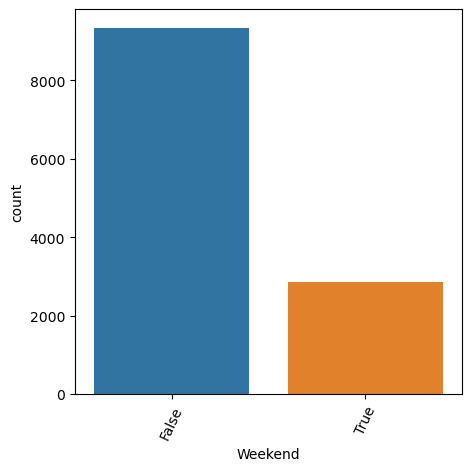

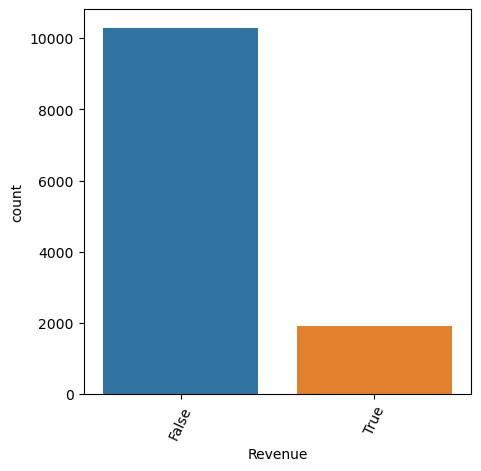

In [16]:
#Bar plots for categorical columns
for i in range (len(categorical_cols)):
    plt.figure(figsize=(5,5))
    sns.countplot(x=data[categorical_cols[i]], data=data)
    plt.xticks(rotation=65) 

In [17]:
#Check for outliers
outliers = outliers_check(data, numeric_cols)

Administrative  2
Administrative_Duration  273
Informational  2631
Informational_Duration  2405
ProductRelated  173
ProductRelated_Duration  166
BounceRates  691
ExitRates  0
PageValues  2730
SpecialDay  1249
OperatingSystems  0
Browser  4322
Region  0
TrafficType  261


# Correlation Analysis

C:\Users\amych\AppData\Local\Temp\ipykernel_6664\3699474598.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


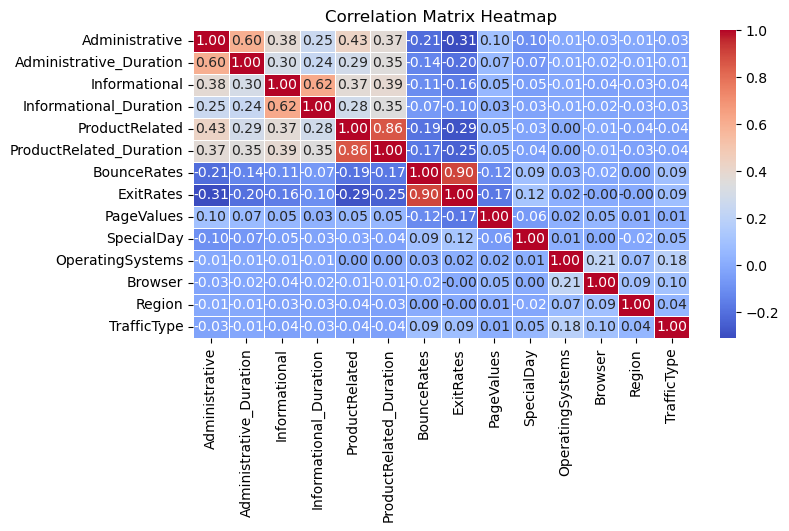

In [18]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Preprocessing

## Remove Outliers

In [19]:
#Remove outliers

removed_outliers = remove_outliers(data, numeric_cols)

## One Hot Encoding

In [20]:
#One hot encoding

data_encoded = oneHotEncoding(removed_outliers, categorical_cols, True)

data_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Revenue_True
0,0,0.0,0,0.0,1,0.000000,0.002899,0.20,0.0,0.0,1,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.10,0.0,0.0,2,2,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0.0,0,0.0,1,0.000000,0.002899,0.20,0.0,0.0,4,2,9,3,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.14,0.0,0.0,3,2,2,4,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.05,0.0,0.0,3,2,1,4,0,1,0,0,0,0,0,0,0,0,1,1,0


In [21]:
data_encoded.shape

(12205, 27)

In [22]:
#Randomise the dataset

data_sampled = data_encoded.sample(frac=1, random_state=42)

#All features except the target are assigned to 'X'
X = data_sampled.drop("Revenue_True", axis=1)

#Target feature is assigned to 'Y'
Y = data_sampled["Revenue_True"]

data_sampled.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Revenue_True
6045,0,0.0,0,0.0,19,1138.793636,0.000,0.007018,0.0,0.0,2,2,3,2,0,0,0,0,0,0,0,0,0,0,1,0,0
7750,3,273.0,0,0.0,11,385.740000,0.000,0.007692,0.0,0.0,2,2,1,2,0,0,0,0,0,0,0,1,0,0,1,0,1
203,0,0.0,0,0.0,3,133.500000,0.000,0.088889,0.0,0.0,1,2,1,8,0,0,0,0,1,0,0,0,0,0,1,0,0
10452,0,0.0,0,0.0,27,630.750000,0.016,0.020000,0.0,0.0,2,2,3,1,0,0,0,0,0,0,1,0,0,0,1,1,0
1177,2,52.0,0,0.0,18,1262.000000,0.000,0.009524,0.0,0.0,2,2,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0


# Dataset Rebalancing

Undersampling and Oversampling sampling methods were used for modelling. Results for both methods will be compared to the result of modelling without any sampling method.

Rebalancing is done on the training set only.

In [23]:
#split into train and test

x, xtest, y, ytest = train_test_split(X, Y, test_size=0.2, random_state=None)
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.3, random_state=None)

In [24]:
#Undersampling

undersampling = RandomUnderSampler(random_state=42)

xtrain_undersampled, ytrain_undersampled = undersampling.fit_resample(xtrain, ytrain)

xtrain_undersampled.shape

(2118, 26)

In [25]:
#Oversampling

oversampling = RandomOverSampler(random_state=42)

xtrain_oversampled, ytrain_oversampled = oversampling.fit_resample(xtrain, ytrain)

xtrain_oversampled.shape

(11550, 26)

In [26]:
#Data is now balanced

print("Undersampled:\n", ytrain_undersampled.value_counts())

print("\nOversampled:\n", ytrain_oversampled.value_counts())

Undersampled:
 0    1059
1    1059
Name: Revenue_True, dtype: int64

Oversampled:
 0    5775
1    5775
Name: Revenue_True, dtype: int64


# Dataset Scaling

Both oversampled and undersampled datasets are scaled and PCA will be applied to them

In [28]:
#Scaling the data - oversampled dataset & undersampled

scaler = StandardScaler()

#Transform data
xtrain_oversampled[numeric_cols] = scaler.fit_transform(xtrain_oversampled[numeric_cols])
xtrain_undersampled[numeric_cols] = scaler.fit_transform(xtrain_undersampled[numeric_cols])


xtest[numeric_cols] = scaler.transform(xtest[numeric_cols])
xval[numeric_cols] = scaler.transform(xval[numeric_cols])



xtrain_oversampled.shape

(11550, 26)

# Dimensionality Reduction Using Principal Component Analysis

In [29]:
#PCA - undersampled dataset

#Initialize PCA with the desired number of features (components). 2 features are removed making 24
pca_undersampled = PCA(n_components=24)

#Fit PCA on the training data
pca_undersampled.fit(xtrain_undersampled)

# Transform both the training and testing data
xtrain_pca_undersampled = pca_undersampled.transform(xtrain_undersampled)
xval_pca_undersampled = pca_undersampled.transform(xval)
xtest_pca_undersampled = pca_undersampled.transform(xtest)

In [30]:
#PCA - oversampled dataset

#Initialize PCA with the desired number of features (components). 2 features are removed making 24
pca = PCA(n_components=24)

# Fit PCA on the training data
pca.fit(xtrain_oversampled)

#Transform both training and testing data
xtrain_pca_oversampled = pca.transform(xtrain_oversampled)
xval_pca_oversampled = pca.transform(xval)
xtest_pca_oversampled = pca.transform(xtest)

print("Shape of xtrain_pca_undersampled:", xtrain_pca_oversampled.shape)
print("Shape of ytrain:", ytrain_oversampled.shape)

print("Unique labels in ytrain:", np.unique(ytrain))
print("Number of unique labels:", len(np.unique(ytrain)))

Shape of xtrain_pca_undersampled: (11550, 24)
Shape of ytrain: (11550,)
Unique labels in ytrain: [0 1]
Number of unique labels: 2


# Modelling

## Decision Tree

Modelling will be done on the dataset after scaling, and the dataset after PCA

In [30]:
#List to hold models and data for result compilation
DT_models = []
DT_name = []
x_val_list = []
x_test_list = []

In [31]:
#hyperparameter
ccp_alpha = 0.005
txt = "ccp_alpha: 0.005"

In [32]:
#DecsionTree model - oversampled dataset

#Initialize the decision tree classifier
clf_oversampled = DecisionTreeClassifier()

#append the lists
DT_models.append(clf_oversampled)
DT_name.append(f"Oversampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)


#Fit the classifier to the training data
clf_oversampled.fit(xtrain_oversampled, ytrain_oversampled)

DecisionTreeClassifier()

In [33]:
#DecsionTree model - undersampled dataset

#Initialize the decision tree classifier
clf_undersampled = DecisionTreeClassifier()

#append the list
DT_models.append(clf_undersampled)
DT_name.append(f"Undersampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
clf_undersampled.fit(xtrain_undersampled, ytrain_undersampled)

DecisionTreeClassifier()

In [34]:
#DecsionTree model - oversampled dataset

#Initialize the decision tree classifier
clf_oversampled_pca = DecisionTreeClassifier()

#append the list
DT_models.append(clf_oversampled_pca)
DT_name.append(f"Oversampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

#Fit the classifier to the training data
clf_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

DecisionTreeClassifier()

In [35]:
#DecsionTree model - undersampled dataset

#Initialize the decision tree classifier
clf_undersampled_pca = DecisionTreeClassifier()

DT_models.append(clf_undersampled_pca)
DT_name.append(f"Undersampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

#Fit the classifier to the training data
clf_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)

DecisionTreeClassifier()

In [40]:
#prediction function
def predict(models, names, x_list, Y, eval_type):
    
    print(f"\033[1mEvaluating {eval_type} data\033[0m \n")
    
    fpr_list, tpr_list, roc_auc_list = [], [], []
    
    for model, name, X in zip(models, names, x_list):
        print(f"\033[1mEvaluating {name}...\033[0m")
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred) #accuracy
        report = classification_report(Y, y_pred) #classification report
        print(f"{name} Accuracy:", accuracy)
        
        
        conf_matrix = confusion_matrix(Y, y_pred) #confusion matrix
        
        #plot confusion matrix
        plt.figure(figsize=(3, 2))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print(f"{name} Classification report:\n", report)

    
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(Y, y_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        
        roc_auc = auc(fpr, tpr) #ROC
        #print(f"{name} AUC = {roc_auc}")
        roc_auc_list.append(roc_auc)
        
    #source: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    cmap = plt.colormaps['tab10']
    colors = cmap.colors[:len(names)]
    plt.figure(figsize=(9,5))
    
    #plot ROC
    for i, (fpr, tpr, roc_auc, name) in enumerate(zip(fpr_list, tpr_list, roc_auc_list, names)):
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC). MLP on Dataset 1')
    plt.legend(loc='lower right')
    plt.show()

Evaluating validation data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.005...
Oversampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.7808873720136519


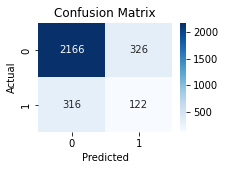

Oversampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2492
           1       0.27      0.28      0.28       438

    accuracy                           0.78      2930
   macro avg       0.57      0.57      0.57      2930
weighted avg       0.78      0.78      0.78      2930

Evaluating Undersampled dataset(No PCA), ccp_alpha: 0.005...
Undersampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.6218430034129693


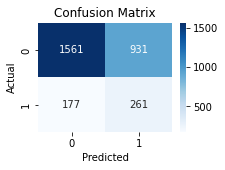

Undersampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.90      0.63      0.74      2492
           1       0.22      0.60      0.32       438

    accuracy                           0.62      2930
   macro avg       0.56      0.61      0.53      2930
weighted avg       0.80      0.62      0.68      2930

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.005...
Oversampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.7750853242320819


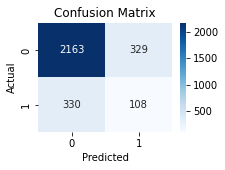

Oversampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2492
           1       0.25      0.25      0.25       438

    accuracy                           0.78      2930
   macro avg       0.56      0.56      0.56      2930
weighted avg       0.77      0.78      0.77      2930

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.005...
Undersampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.6023890784982935


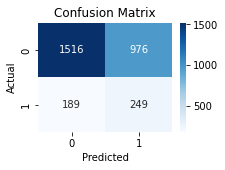

Undersampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72      2492
           1       0.20      0.57      0.30       438

    accuracy                           0.60      2930
   macro avg       0.55      0.59      0.51      2930
weighted avg       0.79      0.60      0.66      2930



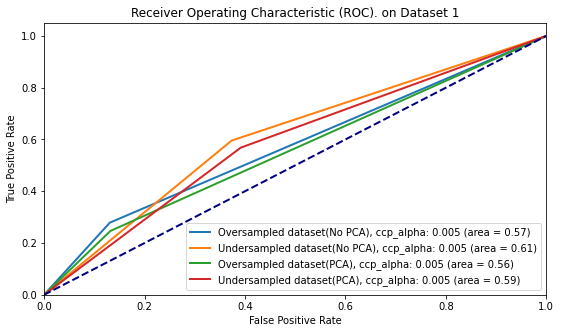

In [38]:
predict(DT_models, DT_name, x_val_list, yval, "validation")

Evaluating testing data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.005...
Oversampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.7853338795575584


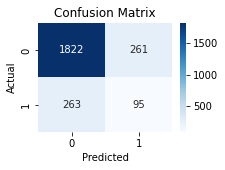

Oversampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2083
           1       0.27      0.27      0.27       358

    accuracy                           0.79      2441
   macro avg       0.57      0.57      0.57      2441
weighted avg       0.78      0.79      0.79      2441

Evaluating Undersampled dataset(No PCA), ccp_alpha: 0.005...
Undersampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.6206472757066775


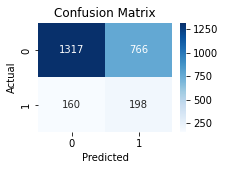

Undersampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.63      0.74      2083
           1       0.21      0.55      0.30       358

    accuracy                           0.62      2441
   macro avg       0.55      0.59      0.52      2441
weighted avg       0.79      0.62      0.68      2441

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.005...
Oversampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.7849242113887751


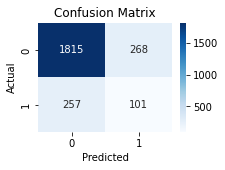

Oversampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2083
           1       0.27      0.28      0.28       358

    accuracy                           0.78      2441
   macro avg       0.57      0.58      0.58      2441
weighted avg       0.79      0.78      0.79      2441

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.005...
Undersampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.5870544858664482


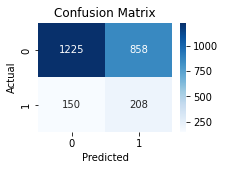

Undersampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.59      0.71      2083
           1       0.20      0.58      0.29       358

    accuracy                           0.59      2441
   macro avg       0.54      0.58      0.50      2441
weighted avg       0.79      0.59      0.65      2441



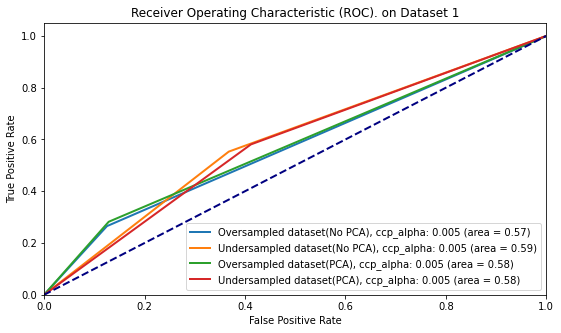

In [39]:
predict(DT_models, DT_name, x_test_list, ytest, "testing")

### Using the oversampled dataset with PCA for hyperparameter tuning because of its high performance

Accuracy Score on train data:  0.64627752534079


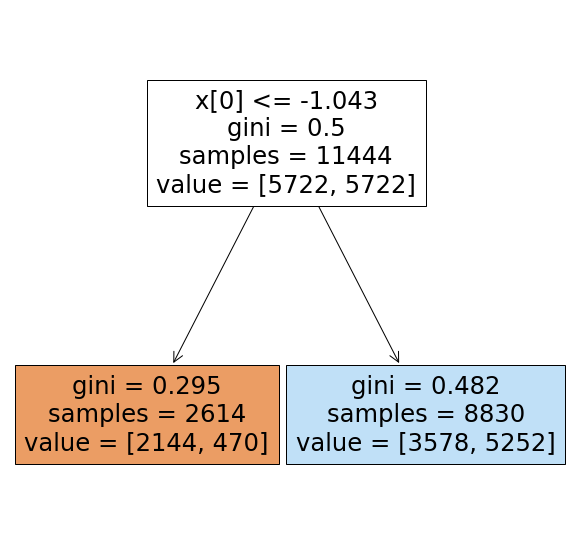

In [40]:
clf_oversampled_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=0.010)

#Fit the classifier
clf_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

#Evaluate the model on the PCA-transformed test data
y_pred_test_dt_pca = clf_oversampled_pca.predict(xtest_pca_oversampled)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_oversampled, y_pred=clf_oversampled_pca.predict(xtrain_pca_oversampled)))

DT_models.append(clf_oversampled_pca)
DT_name.append("Oversampled Dataset ccp_alpha: 0.010")
x_test_list.append(xtest_pca_oversampled)

#plot decision tree
plt.figure(figsize=(10,10))
plot_tree(clf_oversampled_pca, filled=True)
plt.show()

Accuracy Score on train data:  0.64627752534079


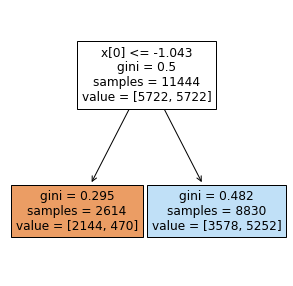

In [41]:
clf_oversampled_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=0.010)

# Fit the classifier
clf_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled,)

# Evaluate the model
y_pred_test_dt_pca = clf_oversampled_pca.predict(xtest_pca_oversampled)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_oversampled, y_pred=clf_oversampled_pca.predict(xtrain_pca_oversampled)))

DT_models.append(clf_oversampled_pca)
DT_name.append("Oversampled Dataset (PCA) ccp_alpha: 0.010")
x_test_list.append(xtest_pca_oversampled)

#plot the decision tree
plt.figure(figsize=(5,5))
plot_tree(clf_oversampled_pca, filled=True)
plt.show()

Evaluating testing data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.005...
Oversampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.7853338795575584


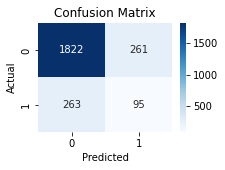

Oversampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2083
           1       0.27      0.27      0.27       358

    accuracy                           0.79      2441
   macro avg       0.57      0.57      0.57      2441
weighted avg       0.78      0.79      0.79      2441

Evaluating Undersampled dataset(No PCA), ccp_alpha: 0.005...
Undersampled dataset(No PCA), ccp_alpha: 0.005 Accuracy: 0.6206472757066775


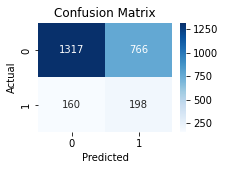

Undersampled dataset(No PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.63      0.74      2083
           1       0.21      0.55      0.30       358

    accuracy                           0.62      2441
   macro avg       0.55      0.59      0.52      2441
weighted avg       0.79      0.62      0.68      2441

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.005...
Oversampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.7849242113887751


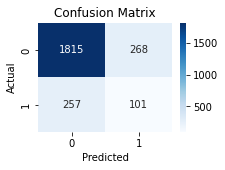

Oversampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2083
           1       0.27      0.28      0.28       358

    accuracy                           0.78      2441
   macro avg       0.57      0.58      0.58      2441
weighted avg       0.79      0.78      0.79      2441

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.005...
Undersampled dataset(PCA), ccp_alpha: 0.005 Accuracy: 0.5870544858664482


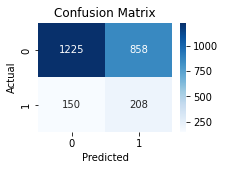

Undersampled dataset(PCA), ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.59      0.71      2083
           1       0.20      0.58      0.29       358

    accuracy                           0.59      2441
   macro avg       0.54      0.58      0.50      2441
weighted avg       0.79      0.59      0.65      2441

Evaluating Oversampled Dataset ccp_alpha: 0.010...
Oversampled Dataset ccp_alpha: 0.010 Accuracy: 0.44285129045473165


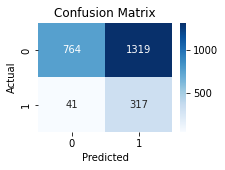

Oversampled Dataset ccp_alpha: 0.010 Classification report:
               precision    recall  f1-score   support

           0       0.95      0.37      0.53      2083
           1       0.19      0.89      0.32       358

    accuracy                           0.44      2441
   macro avg       0.57      0.63      0.42      2441
weighted avg       0.84      0.44      0.50      2441

Evaluating Oversampled Dataset (PCA) ccp_alpha: 0.010...
Oversampled Dataset (PCA) ccp_alpha: 0.010 Accuracy: 0.44285129045473165


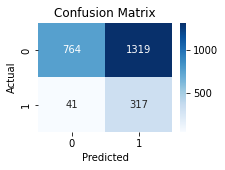

Oversampled Dataset (PCA) ccp_alpha: 0.010 Classification report:
               precision    recall  f1-score   support

           0       0.95      0.37      0.53      2083
           1       0.19      0.89      0.32       358

    accuracy                           0.44      2441
   macro avg       0.57      0.63      0.42      2441
weighted avg       0.84      0.44      0.50      2441



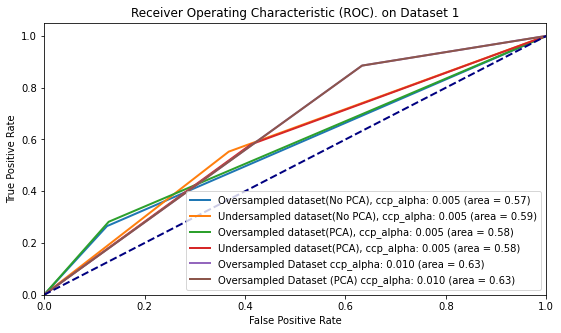

In [42]:
predict(DT_models, DT_name, x_test_list, ytest, "testing")

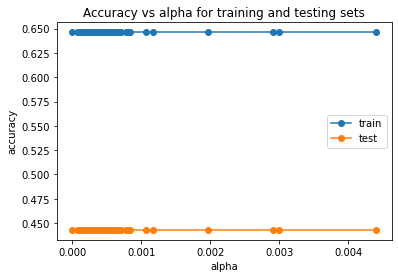

In [43]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf_oversampled_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=0.015)
    clf_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)
    clfs.append(clf_oversampled_pca)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Calculate training and testing scores for each classifier
train_scores = [clf.score(xtrain_pca_oversampled, ytrain_oversampled) for clf in clfs]
test_scores = [clf.score(xtest_pca_oversampled, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Support Vector Machine (SVM)

In [44]:
SVM_models = []
SVM_name = []
x_val_list = []
x_test_list = []

In [45]:
gamma=0.1
txt = "gamma: 0.1"

In [46]:
#SVM model - oversampled dataset

# Initialize the SVM classifier
svm_oversampled = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(svm_oversampled)
SVM_name.append(f"Oversampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
svm_oversampled.fit(xtrain_oversampled, ytrain_oversampled)


SVC(gamma=0.1, probability=True, random_state=42)

In [47]:
#SVM model - undersampled dataset

#Initialize the SVM classifier
svm_undersampled = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(svm_undersampled)
SVM_name.append(f"Undersampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

# Fit the classifier to the training data
svm_undersampled.fit(xtrain_undersampled, ytrain_undersampled)

SVC(gamma=0.1, probability=True, random_state=42)

In [48]:
#SVM model - oversampled dataset

#Initialize the SVM classifier
svm_oversampled_pca = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(svm_oversampled_pca)
SVM_name.append(f"Oversampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

#Fit the classifier to the training data
svm_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

SVC(gamma=0.1, probability=True, random_state=42)

In [49]:
#SVM model - undersampled dataset

# Initialize the SVM classifier
svm_undersampled_pca = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(clf_undersampled_pca)
SVM_name.append(f"Undersampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

# Fit the classifier to the training data
svm_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)

SVC(gamma=0.1, probability=True, random_state=42)

Evaluating SVM validation data 

Evaluating Oversampled dataset(No PCA), gamma: 0.1...
Oversampled dataset(No PCA), gamma: 0.1 Accuracy: 0.674061433447099


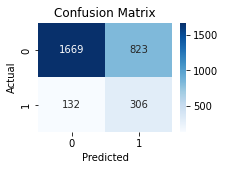

Oversampled dataset(No PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      2492
           1       0.27      0.70      0.39       438

    accuracy                           0.67      2930
   macro avg       0.60      0.68      0.58      2930
weighted avg       0.83      0.67      0.72      2930

Evaluating Undersampled dataset(No PCA), gamma: 0.1...
Undersampled dataset(No PCA), gamma: 0.1 Accuracy: 0.6293515358361774


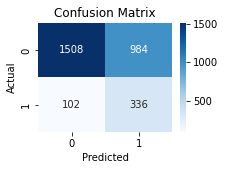

Undersampled dataset(No PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.94      0.61      0.74      2492
           1       0.25      0.77      0.38       438

    accuracy                           0.63      2930
   macro avg       0.60      0.69      0.56      2930
weighted avg       0.83      0.63      0.68      2930

Evaluating Oversampled dataset(PCA), gamma: 0.1...
Oversampled dataset(PCA), gamma: 0.1 Accuracy: 0.674061433447099


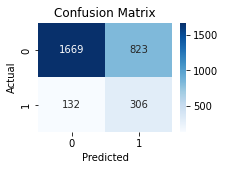

Oversampled dataset(PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      2492
           1       0.27      0.70      0.39       438

    accuracy                           0.67      2930
   macro avg       0.60      0.68      0.58      2930
weighted avg       0.83      0.67      0.72      2930

Evaluating Undersampled dataset(PCA), gamma: 0.1...
Undersampled dataset(PCA), gamma: 0.1 Accuracy: 0.6023890784982935


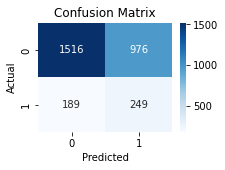

Undersampled dataset(PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72      2492
           1       0.20      0.57      0.30       438

    accuracy                           0.60      2930
   macro avg       0.55      0.59      0.51      2930
weighted avg       0.79      0.60      0.66      2930



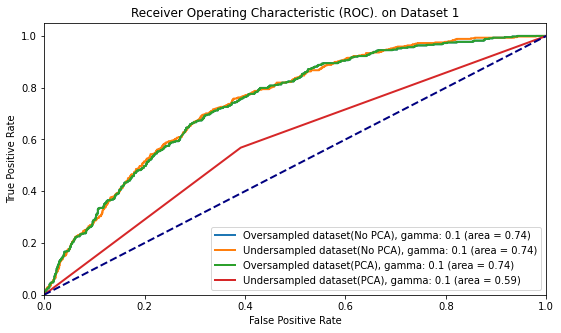

In [50]:
predict(SVM_models, SVM_name, x_val_list, yval, "SVM validation")

Evaluating SVM testing data 

Evaluating Oversampled dataset(No PCA), gamma: 0.1...
Oversampled dataset(No PCA), gamma: 0.1 Accuracy: 0.6812781646866038


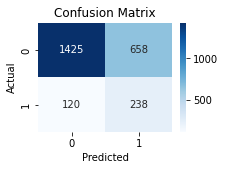

Oversampled dataset(No PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.79      2083
           1       0.27      0.66      0.38       358

    accuracy                           0.68      2441
   macro avg       0.59      0.67      0.58      2441
weighted avg       0.83      0.68      0.73      2441

Evaluating Undersampled dataset(No PCA), gamma: 0.1...
Undersampled dataset(No PCA), gamma: 0.1 Accuracy: 0.6329373207701762


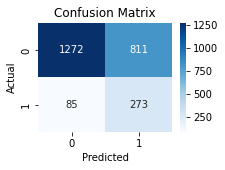

Undersampled dataset(No PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.94      0.61      0.74      2083
           1       0.25      0.76      0.38       358

    accuracy                           0.63      2441
   macro avg       0.59      0.69      0.56      2441
weighted avg       0.84      0.63      0.69      2441

Evaluating Oversampled dataset(PCA), gamma: 0.1...
Oversampled dataset(PCA), gamma: 0.1 Accuracy: 0.6812781646866038


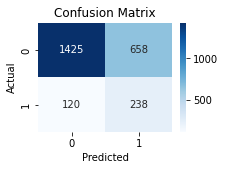

Oversampled dataset(PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.79      2083
           1       0.27      0.66      0.38       358

    accuracy                           0.68      2441
   macro avg       0.59      0.67      0.58      2441
weighted avg       0.83      0.68      0.73      2441

Evaluating Undersampled dataset(PCA), gamma: 0.1...
Undersampled dataset(PCA), gamma: 0.1 Accuracy: 0.5870544858664482


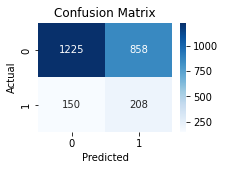

Undersampled dataset(PCA), gamma: 0.1 Classification report:
               precision    recall  f1-score   support

           0       0.89      0.59      0.71      2083
           1       0.20      0.58      0.29       358

    accuracy                           0.59      2441
   macro avg       0.54      0.58      0.50      2441
weighted avg       0.79      0.59      0.65      2441



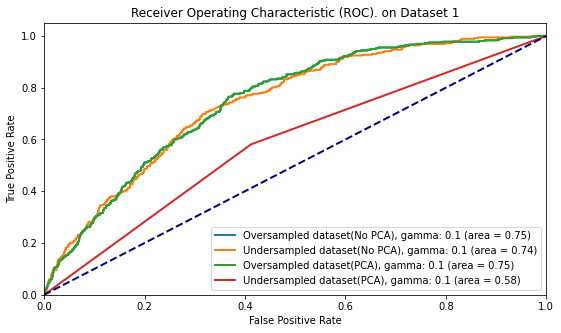

In [51]:
predict(SVM_models, SVM_name, x_test_list, ytest, "SVM testing")

## Multi Layer Perceptron

In [32]:
MLP_models = []
MLP_name = []
x_val_list = []
x_test_list = []

In [33]:
from sklearn.neural_network import MLPClassifier


mlp_oversampled = MLPClassifier(random_state=42)
MLP_models.append(mlp_oversampled)
MLP_name.append(f"Oversampled dataset(No PCA)")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
mlp_oversampled.fit(xtrain_oversampled, ytrain_oversampled)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [34]:
mlp_undersampled = MLPClassifier(random_state=42)


MLP_models.append(mlp_undersampled)
MLP_name.append(f"Undersampled dataset(No PCA)")
x_val_list.append(xval)
x_test_list.append(xtest)

# Fit the classifier to the training data
mlp_undersampled.fit(xtrain_undersampled, ytrain_undersampled)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [35]:
mlp_oversampled_pca = MLPClassifier(random_state=42)

MLP_models.append(mlp_oversampled_pca)
MLP_name.append(f"Oversampled dataset(PCA)")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

# Fit the classifier to the training data
mlp_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [36]:
mlp_undersampled_pca = MLPClassifier(random_state=42)

MLP_models.append(mlp_undersampled_pca)
MLP_name.append(f"Undersampled dataset(PCA)")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

#Fit the classifier to the training data
mlp_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

Evaluating MLP validation data 

Evaluating Oversampled dataset(No PCA)...
Oversampled dataset(No PCA) Accuracy: 0.7139931740614335


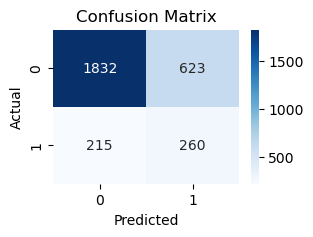

Oversampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.81      2455
           1       0.29      0.55      0.38       475

    accuracy                           0.71      2930
   macro avg       0.59      0.65      0.60      2930
weighted avg       0.80      0.71      0.74      2930

Evaluating Undersampled dataset(No PCA)...
Undersampled dataset(No PCA) Accuracy: 0.6412969283276451


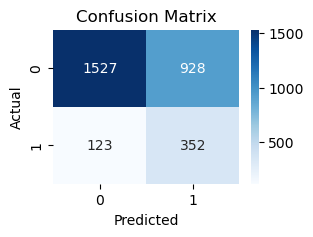

Undersampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.74      2455
           1       0.28      0.74      0.40       475

    accuracy                           0.64      2930
   macro avg       0.60      0.68      0.57      2930
weighted avg       0.82      0.64      0.69      2930

Evaluating Oversampled dataset(PCA)...
Oversampled dataset(PCA) Accuracy: 0.7225255972696246


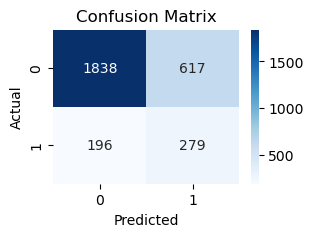

Oversampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      2455
           1       0.31      0.59      0.41       475

    accuracy                           0.72      2930
   macro avg       0.61      0.67      0.61      2930
weighted avg       0.81      0.72      0.75      2930

Evaluating Undersampled dataset(PCA)...
Undersampled dataset(PCA) Accuracy: 0.6351535836177474


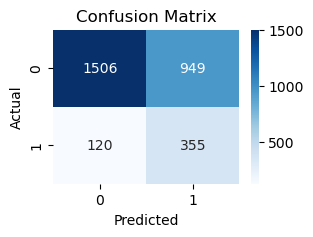

Undersampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

           0       0.93      0.61      0.74      2455
           1       0.27      0.75      0.40       475

    accuracy                           0.64      2930
   macro avg       0.60      0.68      0.57      2930
weighted avg       0.82      0.64      0.68      2930



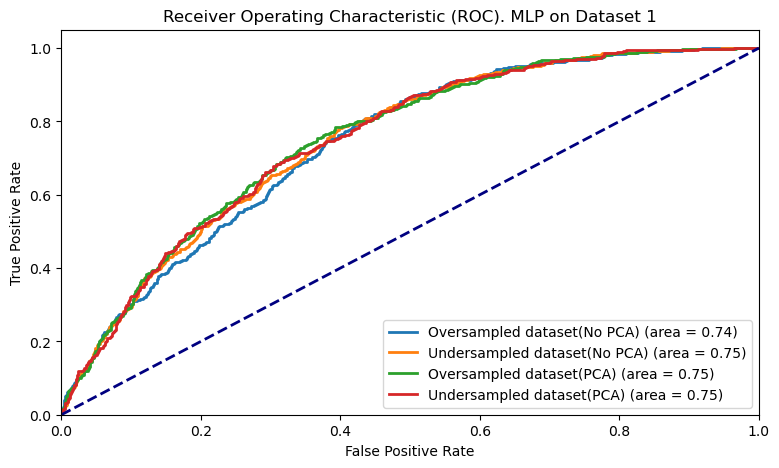

In [41]:
predict(MLP_models, MLP_name, x_val_list, yval, "MLP validation")

Evaluating MLP testing data 

Evaluating Oversampled dataset(No PCA)...
Oversampled dataset(No PCA) Accuracy: 0.7070872593199509


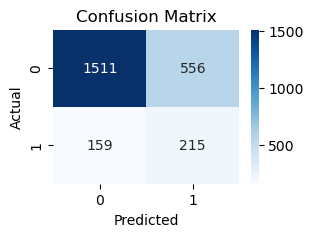

Oversampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      2067
           1       0.28      0.57      0.38       374

    accuracy                           0.71      2441
   macro avg       0.59      0.65      0.59      2441
weighted avg       0.81      0.71      0.74      2441

Evaluating Undersampled dataset(No PCA)...
Undersampled dataset(No PCA) Accuracy: 0.6403113478082753


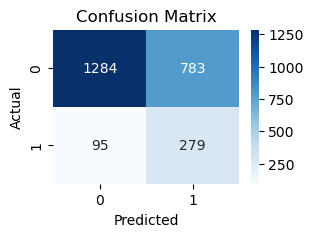

Undersampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.75      2067
           1       0.26      0.75      0.39       374

    accuracy                           0.64      2441
   macro avg       0.60      0.68      0.57      2441
weighted avg       0.83      0.64      0.69      2441

Evaluating Oversampled dataset(PCA)...
Oversampled dataset(PCA) Accuracy: 0.7165096272019664


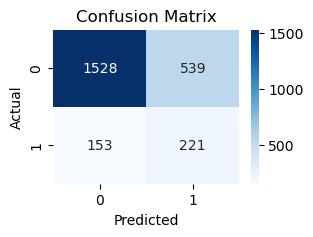

Oversampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      2067
           1       0.29      0.59      0.39       374

    accuracy                           0.72      2441
   macro avg       0.60      0.67      0.60      2441
weighted avg       0.81      0.72      0.75      2441

Evaluating Undersampled dataset(PCA)...
Undersampled dataset(PCA) Accuracy: 0.6419500204834084


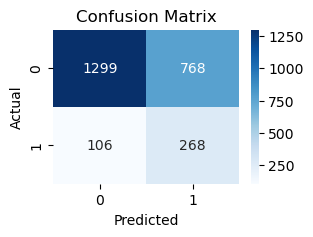

Undersampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

           0       0.92      0.63      0.75      2067
           1       0.26      0.72      0.38       374

    accuracy                           0.64      2441
   macro avg       0.59      0.67      0.56      2441
weighted avg       0.82      0.64      0.69      2441



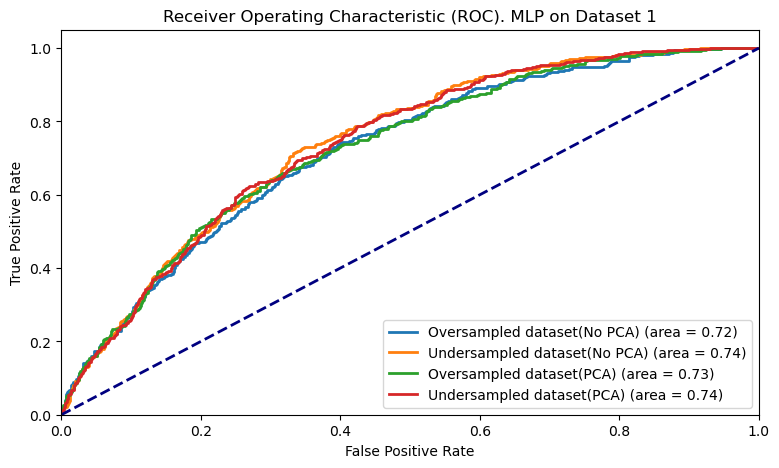

In [42]:
predict(MLP_models, MLP_name, x_test_list, ytest, "MLP testing")

# Cross Validation on Best Performing Datasets

Decision Tree: 0.683330 (0.014182)
SVM: 0.749828 (0.008647)


/user/HS400/ms04010/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/user/HS400/ms04010/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/user/HS400/ms04010/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/user/HS400/ms04010/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/user/HS400/ms04010/

MLP: 0.811432 (0.009344)


/user/HS400/ms04010/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


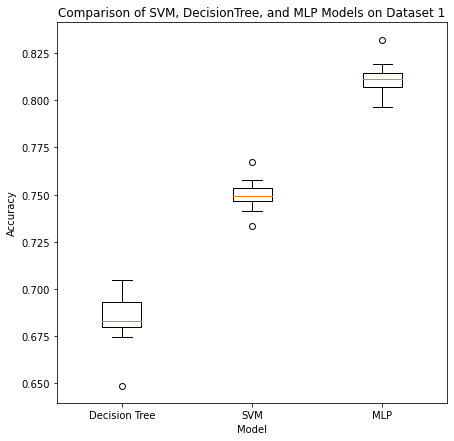

In [61]:
# Initialize the models
models = [
    ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.002)),
    ('SVM', svm.SVC(probability=True, random_state=42, gamma=0.1)),
    ('MLP', MLPClassifier(random_state=42))
]

# Lists to hold models, validation data, and test data
models_list = []
x_val_list = []
x_test_list = []

# Lists to hold results and model names
results = []
names = []

# Evaluate each model in turn
for name, model in models:
    models_list.append(model)
    x_test_list.append(xtest_pca_oversampled)
    kfold = StratifiedKFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, xtrain_pca_oversampled, ytrain_oversampled, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names)
plt.title('Comparison of SVM, DecisionTree, and MLP Models on Dataset 1')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()
